# Libraries

In [2]:
from numpy import mean, std
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
import os

## Load data and resample

In [3]:
# load the dataset
def load_dataset(file_path):
    # load the dataset as a dataframe
    data_df = pd.read_pickle(file_path)
    # correct data types
    fix_cols = data_df.columns[data_df.dtypes == 'object']
    data_df.loc[:, fix_cols] = data_df.loc[:, fix_cols].astype('bool')
    # remove redundant features
    data_df.drop(['total_review_count', 'halal_review_count', 'halal_negation_count'], inplace=True, axis=1)
    # split into features and target
    X, y = data_df.drop('halal', axis=1), data_df.halal
    return X, y

# define resampling method
def split_and_resample(X, y, test_size=0, resampling=None):
    if test_size > 0:
        # setting up testing and training sets
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    else:
        x_train, x_test, y_train, y_test = X, pd.DataFrame(columns=X.columns, dtype=X.dtypes.values),\
                                            y, pd.Series(name=y.name, dtype=y.dtypes)
    # concatenate our training data back together
    X = pd.concat([x_train, y_train], axis=1)
    # separate minority and majority classes
    min_class = X[X.halal==X.halal.value_counts().sort_values().index[0]]
    max_class = X[X.halal==X.halal.value_counts().sort_values().index[1]]
    if not resampling:
        return x_train, y_train, x_test, y_test
    # oversampling minority
    if resampling == 'oversample':
        new_min_class = resample(min_class, replace=True, n_samples=(len(max_class)))
        upsampled = pd.concat([max_class, new_min_class])
        return upsampled.drop('halal', axis=1), upsampled.halal, x_test, y_test
    elif resampling == 'undersample':
        new_max_class = resample(max_class, replace=True, n_samples=(len(min_class)))
        downsampled = pd.concat([new_max_class, min_class])
        return downsampled.drop('halal', axis=1), downsampled.halal, x_test, y_test
    elif resampling == 'SMOTE':
        x_train, y_train = SMOTE().fit_sample(x_train, y_train)
        return x_train, y_train, x_test, y_test

# define models to test
def get_models():
    models = list()
    # BASE
    models.append(DummyClassifier(strategy='constant', constant=1))
    # CART
    models.append(DecisionTreeClassifier(max_depth=15)) # max depth set to 15 to avoid overfitting
    # KNN
    steps = [('s',StandardScaler()),('m',KNeighborsClassifier())]
    models.append(Pipeline(steps=steps))
    # RF
    models.append(RandomForestClassifier(n_estimators=10, max_depth=15))
    # XGBoost
    models.append(XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=15))
    return models

# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
   # calculate precision-recall curve
   p, r, _ = precision_recall_curve(y_true, probas_pred)
   # calculate area under curve
   return auc(r, p)

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, error_score='raise')
    return scores

>DummyClassifier 0.866 (0.003)
>DecisionTreeClassifier 0.880 (0.023)
>Pipeline 0.907 (0.020)
>RandomForestClassifier 0.911 (0.027)
>XGBClassifier 0.918 (0.020)


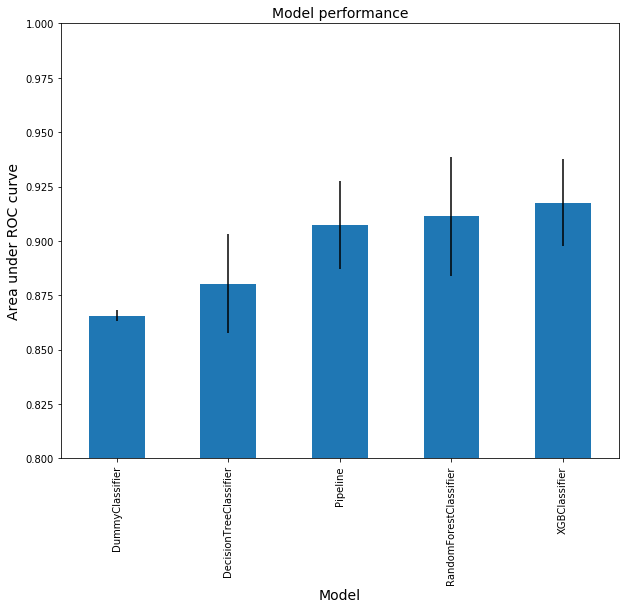

In [186]:
# define the location of the dataset
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num.pkl'
# load the dataset
X, y = load_dataset(file_path)
# split to train and test
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2)

# define models
models = get_models()
# evaluate each model
results = list()
for i, model in enumerate(models):
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, model)
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (model.__class__.__name__, mean(scores), std(scores)))

# plot the results
plot_df = pd.DataFrame(columns=['models', 'results'])
plot_df['models'] = [model.__class__.__name__ for model in models]
plot_df['results'] = [result.tolist() for result in results]
plot_df['mean'] = plot_df['results'].apply(mean)
plot_df['sd'] = plot_df['results'].apply(std)
ax = plot_df.plot(kind='bar', y='mean', x='models', yerr='sd', legend=False, figsize=(10,8))
ax.set_ylim(0.8,1)
ax.set_title('Model performance', size=14)
ax.set_xlabel('Model', size=14)
ax.set_ylabel('Area under ROC curve', size=14)
plt.show()

## Compare different resampling methods

In [209]:
# define the location of the dataset
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num.pkl'
# load the dataset
X, y = load_dataset(file_path)
# define models and resampling methods
models = get_models()
resampling = [None, 'oversample', 'undersample', 'SMOTE']
# evaluate each model
results = list()
for resample_method in resampling:
    # split and oversample
    X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling=resample_method)
    print('>>%s: ' % str(resample_method).upper())
    for model in models:
        # evaluate the model and store results
        scores = evaluate_model(X_train, y_train, model)
        results.append(scores)
        # summarize performance
        print('>%s %.3f (%.3f)' % (model.__class__.__name__, scores.mean(), scores.std()))
        # evaluate against test set
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(' >accuracy: %.3f'  % accuracy_score(y_test, y_pred))
        print(' >recall: %.3f' % recall_score(y_test, y_pred))
    print()

>>NONE: 
>DummyClassifier 0.867 (0.003)
 >accuracy: 0.720
 >recall: 1.000
>DecisionTreeClassifier 0.885 (0.030)
 >accuracy: 0.702
 >recall: 0.777
>Pipeline 0.906 (0.027)
 >accuracy: 0.738
 >recall: 0.818
>RandomForestClassifier 0.909 (0.028)
 >accuracy: 0.780
 >recall: 0.884
>XGBClassifier 0.916 (0.031)
 >accuracy: 0.762
 >recall: 0.860

>>OVERSAMPLE: 
>DummyClassifier 0.750 (0.002)
 >accuracy: 0.714
 >recall: 1.000
>DecisionTreeClassifier 0.914 (0.022)
 >accuracy: 0.708
 >recall: 0.725
>Pipeline 0.881 (0.030)
 >accuracy: 0.738
 >recall: 0.733
>RandomForestClassifier 0.933 (0.024)
 >accuracy: 0.744
 >recall: 0.742
>XGBClassifier 0.940 (0.023)
 >accuracy: 0.732
 >recall: 0.767

>>UNDERSAMPLE: 
>DummyClassifier 0.750 (0.000)
 >accuracy: 0.732
 >recall: 1.000
>DecisionTreeClassifier 0.795 (0.058)
 >accuracy: 0.661
 >recall: 0.618
>Pipeline 0.833 (0.057)
 >accuracy: 0.685
 >recall: 0.650
>RandomForestClassifier 0.834 (0.080)
 >accuracy: 0.690
 >recall: 0.650
>XGBClassifier 0.834 (0.081)
 >

## Feature importance from Random Forest w/ oversampling

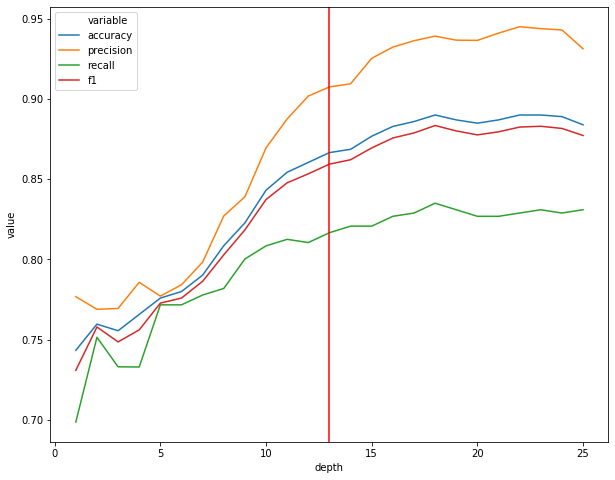

In [6]:
# define the location of the dataset
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num.pkl'
# load the dataset
X, y = load_dataset(file_path)
# split and oversample
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling='oversample')
# initialize RF with different depths
depths = range(1, 26)
plot_df = pd.DataFrame(columns=['depth', 'accuracy', 'precision', 'recall', 'f1'], dtype=float)
plot_df['depth'] = depths
scoring = {'acc': 'accuracy', 'prec': 'precision', 'rec': 'recall', 'f1': 'f1'}

for i, depth in plot_df['depth'].iteritems(): 
    model = RandomForestClassifier(max_depth=depth)
    # train model and collect metrics
    cv_scores = cross_validate(model, X_train, y_train, scoring = scoring, cv = 5, n_jobs = -1)
    plot_df.loc[i, 'accuracy'] = cv_scores['test_acc'].mean()
    plot_df.loc[i, 'precision'] = cv_scores['test_prec'].mean()
    plot_df.loc[i, 'recall'] = cv_scores['test_rec'].mean()
    plot_df.loc[i, 'f1'] = cv_scores['test_f1'].mean()
    
# visualize decision tree metrics vs max_depth
plt.figure(figsize=(10,8))
sns.lineplot(x='depth', y='value', hue='variable', data=pd.melt(plot_df, ['depth']))
plt.axvline(x=13, color='red')
plt.show()

Accuracy:  0.732
Precision: 0.811
Recall:    0.818
f1:        0.815
Confusion matrix: 
 [[24 23]
 [22 99]]
Classification report: 
               precision    recall  f1-score   support

       False       0.52      0.51      0.52        47
        True       0.81      0.82      0.81       121

    accuracy                           0.73       168
   macro avg       0.67      0.66      0.67       168
weighted avg       0.73      0.73      0.73       168



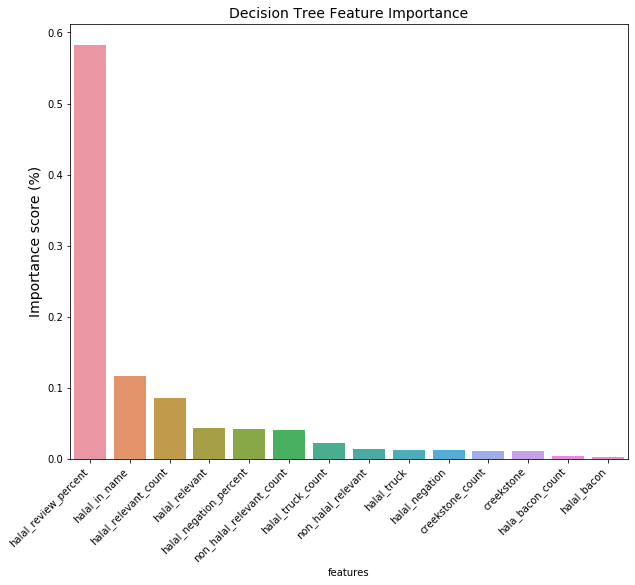

In [12]:
# use max depth of 13
model = RandomForestClassifier(max_depth=13)
model.fit(X_train, y_train)

# model performance on test set
y_pred = model.predict(X_test)
print('Accuracy:  %.3f'  % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall:    %.3f' % recall_score(y_test, y_pred))
print('f1:        %.3f' % f1_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

# Feature importance from RF
plot_df = pd.DataFrame(data={'importances': model.feature_importances_, 'features': X.columns})

# plot
plt.figure(figsize=(10,8))
g = sns.barplot(x=plot_df['features'], y=plot_df['importances'],
                order=plot_df.sort_values('importances', ascending=False).features)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('Decision Tree Feature Importance', size=14)
g.set_ylabel('Importance score (%)', size=14)
plt.show()

## Trying RF with class_weight

In [219]:
# split and oversample
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2)

# define grid
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, {0:25, 1:75}]
param_grid = dict(class_weight=balance)

# define model
model = DecisionTreeClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.667042 using {'class_weight': {0: 1, 1: 1}}
0.643445 (0.055803) with: {'class_weight': {0: 100, 1: 1}}
0.651658 (0.052952) with: {'class_weight': {0: 10, 1: 1}}
0.667042 (0.049766) with: {'class_weight': {0: 1, 1: 1}}
0.657505 (0.057326) with: {'class_weight': {0: 1, 1: 10}}
0.663196 (0.051877) with: {'class_weight': {0: 1, 1: 100}}
0.665115 (0.040679) with: {'class_weight': {0: 25, 1: 75}}


### There is not significant difference between different weights.

## Feature importance from XGBoost

In [18]:
## tuning xgboost
# split data
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2)

## training and tuning model
params = {
    # Parameters to tune
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 0.8,
    'colsample_bytree': 1,
}
model = XGBClassifier(max_depth=12,
                        subsample=0.8,
                        n_estimators=300,
                        learning_rate = 0.01)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train.values.ravel(), early_stopping_rounds=15,
          eval_metric=['aucpr', "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-aucpr:0.95057	validation_0-logloss:0.68808	validation_1-aucpr:0.90923	validation_1-logloss:0.68904
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-aucpr:0.96020	validation_0-logloss:0.68306	validation_1-aucpr:0.91590	validation_1-logloss:0.68480
[2]	validation_0-aucpr:0.96398	validation_0-logloss:0.67819	validation_1-aucpr:0.91580	validation_1-logloss:0.68100
[3]	validation_0-aucpr:0.96471	validation_0-logloss:0.67323	validation_1-aucpr:0.91448	validation_1-logloss:0.67711
[4]	validation_0-aucpr:0.96517	validation_0-logloss:0.66841	validation_1-aucpr:0.92061	validation_1-logloss:0.67346
[5]	validation_0-aucpr:0.96578	validation_0-logloss:0.66376	validation_1-aucpr:0.91836	validation_1-logloss:0.67012
[6]	validation_0-aucpr:0.96611	validation_0-logloss:0.65905	validation_1-aucpr:0.91965	validation_1-logloss:0.66678
[7]	validation_0-aucpr:

[69]	validation_0-aucpr:0.97461	validation_0-logloss:0.46665	validation_1-aucpr:0.90996	validation_1-logloss:0.53812
[70]	validation_0-aucpr:0.97463	validation_0-logloss:0.46466	validation_1-aucpr:0.90980	validation_1-logloss:0.53689
[71]	validation_0-aucpr:0.97467	validation_0-logloss:0.46268	validation_1-aucpr:0.91013	validation_1-logloss:0.53550
[72]	validation_0-aucpr:0.97471	validation_0-logloss:0.46085	validation_1-aucpr:0.90970	validation_1-logloss:0.53453
[73]	validation_0-aucpr:0.97466	validation_0-logloss:0.45896	validation_1-aucpr:0.90993	validation_1-logloss:0.53338
[74]	validation_0-aucpr:0.97484	validation_0-logloss:0.45703	validation_1-aucpr:0.90981	validation_1-logloss:0.53228
[75]	validation_0-aucpr:0.97508	validation_0-logloss:0.45509	validation_1-aucpr:0.90929	validation_1-logloss:0.53141
[76]	validation_0-aucpr:0.97531	validation_0-logloss:0.45329	validation_1-aucpr:0.90970	validation_1-logloss:0.53031
[77]	validation_0-aucpr:0.97527	validation_0-logloss:0.45156	val

[139]	validation_0-aucpr:0.97887	validation_0-logloss:0.36713	validation_1-aucpr:0.90752	validation_1-logloss:0.49378
[140]	validation_0-aucpr:0.97895	validation_0-logloss:0.36615	validation_1-aucpr:0.90666	validation_1-logloss:0.49364
[141]	validation_0-aucpr:0.97903	validation_0-logloss:0.36518	validation_1-aucpr:0.90656	validation_1-logloss:0.49329
[142]	validation_0-aucpr:0.97910	validation_0-logloss:0.36412	validation_1-aucpr:0.90682	validation_1-logloss:0.49310
[143]	validation_0-aucpr:0.97914	validation_0-logloss:0.36313	validation_1-aucpr:0.90634	validation_1-logloss:0.49293
[144]	validation_0-aucpr:0.97925	validation_0-logloss:0.36208	validation_1-aucpr:0.90707	validation_1-logloss:0.49260
[145]	validation_0-aucpr:0.97936	validation_0-logloss:0.36114	validation_1-aucpr:0.90698	validation_1-logloss:0.49204
[146]	validation_0-aucpr:0.97935	validation_0-logloss:0.36023	validation_1-aucpr:0.90691	validation_1-logloss:0.49156
[147]	validation_0-aucpr:0.97936	validation_0-logloss:0.

[209]	validation_0-aucpr:0.98297	validation_0-logloss:0.31318	validation_1-aucpr:0.90577	validation_1-logloss:0.48279
[210]	validation_0-aucpr:0.98300	validation_0-logloss:0.31260	validation_1-aucpr:0.90588	validation_1-logloss:0.48305
[211]	validation_0-aucpr:0.98303	validation_0-logloss:0.31199	validation_1-aucpr:0.90551	validation_1-logloss:0.48327
[212]	validation_0-aucpr:0.98307	validation_0-logloss:0.31137	validation_1-aucpr:0.90558	validation_1-logloss:0.48330
[213]	validation_0-aucpr:0.98310	validation_0-logloss:0.31083	validation_1-aucpr:0.90537	validation_1-logloss:0.48341
[214]	validation_0-aucpr:0.98312	validation_0-logloss:0.31033	validation_1-aucpr:0.90542	validation_1-logloss:0.48370
[215]	validation_0-aucpr:0.98313	validation_0-logloss:0.30982	validation_1-aucpr:0.90552	validation_1-logloss:0.48379
[216]	validation_0-aucpr:0.98319	validation_0-logloss:0.30929	validation_1-aucpr:0.90538	validation_1-logloss:0.48381
[217]	validation_0-aucpr:0.98324	validation_0-logloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Look into non-halal misclassification (False Positives)

In [270]:
# define the location of the dataset
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num.pkl'
# load the dataset as a dataframe
data_df = pd.read_pickle(file_path)
# correct data types
fix_cols = data_df.columns[data_df.dtypes == 'object']
data_df.loc[:, fix_cols] = data_df.loc[:, fix_cols].astype('bool')

# get indices of FP from RF model
FP_list = y_test.index[(y_test==False) & (y_pred == True)]
FP_list = pd.Series(FP_list, name='platform_id')

# get indices of TN from RF model for comparison
TN_list = y_test.index[(y_test==False) & (y_pred == False)]
TN_list = pd.Series(TN_list, name='platform_id')

# pickle and save both lists
pkl_name1 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/FP_list.pkl'
pkl_name2 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/TN_list.pkl'
FP_list.to_pickle(pkl_name1)
TN_list.to_pickle(pkl_name2)